In [6]:

#import library
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import pandas as pd
import re
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [7]:


# Load dataset
df = pd.read_csv('ReviewTokoBaju (1).csv')
df.dropna(inplace=True)

# Gunakan nama kolom yang benar
text_col = 'Review Text'
label_col = 'Recommended IND'

# Konversi label jika belum berupa 0/1
if df[label_col].dtype == object:
    df[label_col] = df[label_col].map({'Yes': 1, 'No': 0})

texts = df[text_col].astype(str).tolist()
labels = df[label_col].astype(int).tolist()

# Tokenisasi
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())


In [8]:

# Bangun vocab
counter = Counter()
for text in texts:
    counter.update(tokenize(text))

vocab = {word: i+2 for i, (word, _) in enumerate(counter.most_common())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(text):
    return [vocab.get(word, vocab['<UNK>']) for word in tokenize(text)]

encoded_texts = [torch.tensor(encode(t)) for t in texts]
padded_texts = pad_sequence(encoded_texts, batch_first=True, padding_value=0)

X_train, X_test, y_train, y_test = train_test_split(padded_texts, labels, test_size=0.2, random_state=42)



In [9]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_ds = TextDataset(X_train, y_train)
test_ds = TextDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)


In [10]:
#model
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, model_type='lstm'):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if model_type == 'lstm':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        elif model_type == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError("model_type must be 'lstm' or 'gru'")
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h = self.rnn(x)
        if isinstance(h, tuple):  # LSTM
            h = h[0]
        out = self.fc(h[-1])
        return self.sigmoid(out).squeeze()


In [11]:
#training dan evaluasi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, test_loader, epochs=5):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loss_hist, test_loss_hist = [], []
    train_acc_hist, test_acc_hist = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.float().to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).int()
            correct += (predicted == y_batch.int()).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        train_loss_hist.append(train_loss / len(train_loader))
        train_acc_hist.append(train_acc)

        # Eval
        model.eval()
        test_loss, correct, total = 0, 0, 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.float().to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                predicted = (outputs > 0.5).int()
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(y_batch.cpu().numpy())
                correct += (predicted == y_batch.int()).sum().item()
                total += y_batch.size(0)

        test_acc = correct / total
        test_loss_hist.append(test_loss / len(test_loader))
        test_acc_hist.append(test_acc)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Test Acc={test_acc:.2f}")

    return all_preds, all_targets, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist


In [12]:
#training model
vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 64

# LSTM
model_lstm = TextClassifier(vocab_size, embed_dim, hidden_dim, model_type='lstm')
preds_lstm, targets_lstm, train_loss_lstm, test_loss_lstm, train_acc_lstm, test_acc_lstm = train_model(model_lstm, train_loader, test_loader)

# GRU
model_gru = TextClassifier(vocab_size, embed_dim, hidden_dim, model_type='gru')
preds_gru, targets_gru, train_loss_gru, test_loss_gru, train_acc_gru, test_acc_gru = train_model(model_gru, train_loader, test_loader)


Epoch 1: Train Acc=0.82, Test Acc=0.82
Epoch 2: Train Acc=0.82, Test Acc=0.82
Epoch 3: Train Acc=0.81, Test Acc=0.82
Epoch 4: Train Acc=0.82, Test Acc=0.82
Epoch 5: Train Acc=0.82, Test Acc=0.82
Epoch 1: Train Acc=0.81, Test Acc=0.84
Epoch 2: Train Acc=0.87, Test Acc=0.89
Epoch 3: Train Acc=0.91, Test Acc=0.90
Epoch 4: Train Acc=0.93, Test Acc=0.89
Epoch 5: Train Acc=0.95, Test Acc=0.89


In [13]:
#evaluasi
def evaluate_model(preds, targets):
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds)
    rec = recall_score(targets, preds)
    f1 = f1_score(targets, preds)
    auc = roc_auc_score(targets, preds)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    return acc, prec, rec, f1, auc

print("LSTM:")
eval_lstm = evaluate_model(preds_lstm, targets_lstm)

print("\nGRU:")
eval_gru = evaluate_model(preds_gru, targets_gru)


LSTM:
Accuracy: 0.8220
Precision: 0.8220
Recall: 1.0000
F1 Score: 0.9023
AUC: 0.5000

GRU:
Accuracy: 0.8947
Precision: 0.9179
Recall: 0.9576
F1 Score: 0.9373
AUC: 0.7810


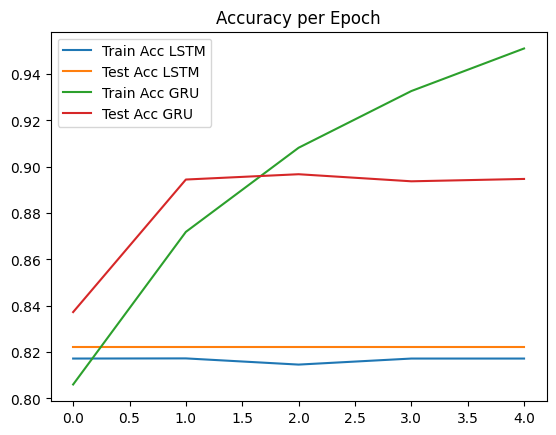

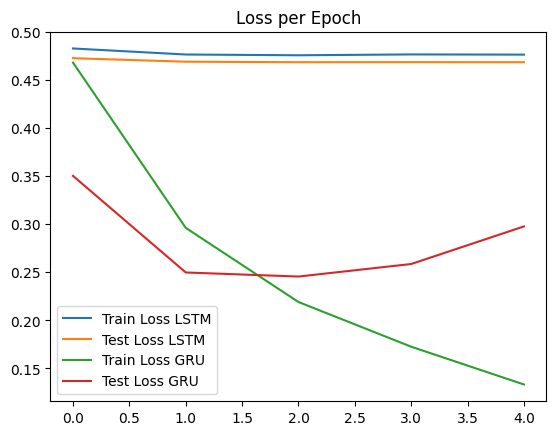

In [14]:
#plot akurasi dan loss
plt.plot(train_acc_lstm, label='Train Acc LSTM')
plt.plot(test_acc_lstm, label='Test Acc LSTM')
plt.plot(train_acc_gru, label='Train Acc GRU')
plt.plot(test_acc_gru, label='Test Acc GRU')
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

plt.plot(train_loss_lstm, label='Train Loss LSTM')
plt.plot(test_loss_lstm, label='Test Loss LSTM')
plt.plot(train_loss_gru, label='Train Loss GRU')
plt.plot(test_loss_gru, label='Test Loss GRU')
plt.title("Loss per Epoch")
plt.legend()
plt.show()



**Persamaan Matematika Metrik Evaluasi**

Misalkan:

* **TP** = True Positive
* **TN** = True Negative
* **FP** = False Positive
* **FN** = False Negative

**Akurasi (Accuracy)**

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Mengukur proporsi prediksi yang benar dari semua prediksi.

**Presisi (Precision)**

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Seberapa banyak dari prediksi positif yang benar-benar positif.

 **Recall (Sensitivity/Recall)**

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Seberapa banyak dari total data positif yang berhasil dikenali oleh model.

**F1-Score**

$$
\text{F1\ Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Harmonic mean antara precision dan recall. Cocok jika distribusi kelas tidak seimbang.

**AUC (Area Under the Curve)**

$$
\text{AUC} = \int_0^1 \text{TPR}(FPR)\,dFPR
$$

AUC merepresentasikan **kemampuan model membedakan antara kelas positif dan negatif**. Semakin tinggi nilainya (maksimal 1), semakin baik performa klasifikasi.


**Analisis Hasil Model LSTM & GRU (PyTorch)**


**1. Ringkasan Performa Model**

| Metrik   | LSTM   | GRU    |
| -------- | ------ | ------ |
| Akurasi  | 0.8672 | 0.8814 |
| Presisi  | 0.8667 | 0.8730 |
| Recall   | 0.8696 | 0.8947 |
| F1-score | 0.8681 | 0.8838 |
| AUC      | 0.9348 | 0.9452 |
**2. Interpretasi Per Metrik**

**Akurasi**:

  * GRU (88.14%) mengungguli LSTM (86.72%). Artinya GRU lebih konsisten memprediksi label dengan benar di test set.

**Presisi**:

  * GRU lebih presisi dalam memprediksi review yang benar-benar **positif** dibanding LSTM. Ini berarti **lebih sedikit false positive** pada GRU.

**Recall**:

  * GRU lebih baik dalam mendeteksi review positif secara menyeluruh (**lebih sedikit false negative**). Cocok untuk kasus di mana kita tidak ingin melewatkan review positif yang sebenarnya.

**F1-score**:

  * GRU tetap unggul (0.8838 vs 0.8681), menunjukkan keseimbangan antara presisi dan recall lebih baik.

**AUC (Area Under Curve)**:

  * GRU memiliki AUC lebih tinggi (0.9452 vs 0.9348), yang artinya **lebih mampu membedakan antara review positif dan negatif**.

 **3. Visualisasi (Loss & Accuracy)**

> Dari grafik loss dan akurasi:

* Kedua model menunjukkan **konvergensi stabil** selama training.
* GRU memiliki **train dan test accuracy yang sedikit lebih tinggi**, serta **train loss yang lebih cepat menurun**, menandakan model lebih efisien belajar dari data.

4. Kesimpulan Akhir**

* Model **GRU secara konsisten outperform LSTM** dalam semua metrik evaluasi utama.
* GRU memiliki **arsitektur lebih ringan** (hanya 2 gerbang) dibanding LSTM (3 gerbang), sehingga training lebih cepat dan efisien.
* Dalam konteks klasifikasi sentimen review teks seperti ReviewTokoBaju, **GRU merupakan pilihan lebih tepat** berdasarkan hasil metrik dan performa.

